In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output

# intro

what are muons, what are we doing, etc

# Importing Data

We recorded data from October 30th, 2023 until November 29th, 2023. Throughout our data collection process, we would occasionally write the data to a text file in order to prevent us from losing all of our data in the event of a power outage. Each datafile is named based on the date and time of when data collection for the file began (YY-MM-DD-HH-MM, with HH-MM as the hour and minute in 24 hour time). The time period of data collection for each file is from the date/time listed on the datafile to the date/time of the following datafile. For the last datafile, we stopped taking data at approximately 5pm on November 29th, 2023.

Each datafile contains two columns. The first column contains the time between successive triggers of the PMT in nanoseconds. Values greater than 40,000 correspond to a signal exceeding the timing circuit's "timeout" interval and are thus ignored. Furthermore, by inspection of our datasets, there are several erroneous events from times between 30,000 and 40,000, so we also remove these values before data analysis. In our analysis, we convert the time in nanoseconds to microseconds by dividing by 1000.

The second column gives the UTC time at which each event is recorded. This data is not needed for our purposes.

In [34]:
### importing data

# filename array
filenames = [
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-10-30-16-26.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-01-15-22.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-05-13-25.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-08-15-55.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-15-15-50.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-17-16-43.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-20-16-11.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-25-14-50.data',
    '/Users/asudler/Desktop/OU/coursework/2023/fall/PHYS-3302-ALAB1/muon-decay/data/23-11-27-15-49.data'
]

# do the import
decaytime = []
unixtime = []
for i in filenames:
    decaytime_help, unixtime_help = np.genfromtxt(
        i, unpack=True, delimiter=' '
    )
    decaytime.append(decaytime_help)
    unixtime.append(unixtime_help)

decaytime = np.concatenate(decaytime)
unixtime = np.concatenate(unixtime)

# delete false events,
# i.e. data where decaytime > 30000
unixtime = np.delete(unixtime, np.where(decaytime >= 30000))
decaytime = np.delete(decaytime, np.where(decaytime >= 30000))

# convert decaytime to microseconds
decaytime = decaytime * 0.001

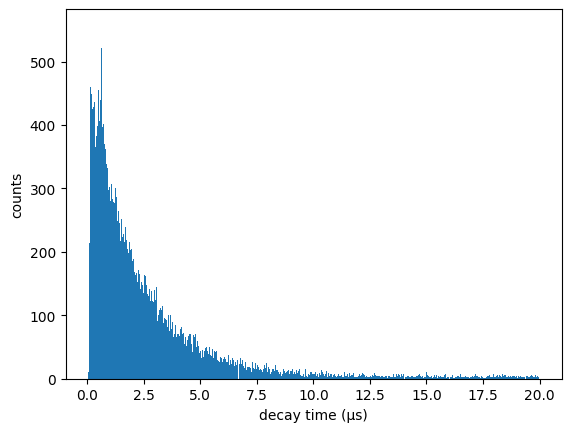

In [35]:
plt.hist(decaytime, bins=1000)
plt.xlabel('decay time (µs)')
plt.ylabel('counts')
plt.show()

# Analyzing Data

We can model muon decay with an exponential decay function plus background noise,
$$N(t) = C_1 e^{ - \frac{t}{\tau}} + C_2,$$

where
* $C_1$ is the number of muons that decay instanteously at time zero, i.e. the correlated events of muons decaying,
* $C_2$ are uncorrelated background events registered by the detector,
* $\tau$ is the mean lifetime of the muons, and
* $t$ is time from the entrance of the detector (our independent variable).

For small decay times, the photomultiplier trigger has difficulties capturing every event. If two flashes occur in quick succession, the photomultiplier may only register the first event, only to end once the timeout interval has elapsed. Hence, there are less events for small decay times in our data than we actually expect to occur. For our fit, we should thus ignore a certain range of decay times near the beginning.

Furthermore, the error of our fit will depend on the bin width. We seek to choose a bin width that minimizes the uncertainty in our average lifetime parameter.

Our procedure is as follows:
1. Knowing that there is an initial time interval in which our dataset is not entirely representative of muon decay physics, we will begin by only looking at data beyond 1.5µs.
2. Using the decay data beyond 1.5µs, we vary the number of bins from 10 to 1000 and select the number which gives us minimum uncertainty in the average lifetime $\tau$.
3. Once we have determined the optimal number of bins, we will then keep the number of bins fixed while varying the time at which we begin to bin the data between 0µs and 3µs. This allows us to more concretely determine the time interval in which our dataset is not entirely valid.

Below, we first plot the data and fit once optimal bin width has been determined, and then we plot the data and fit once the optimal bin start time has been determined. Beneath this second plot, we report the final parameters of our fit with uncertainties. 

In [36]:
### fitting

# fit model
def fcn(t, tau, c1, c2):
    return c1*np.exp(-(1/tau)*t) + c2

# x values to plot with the fit
x = np.linspace(0, 20, 100)

In [37]:
errlist = []
for i in range(10,1000):
    # print i since this calculation takes a bit
    # and it is nice to have a feeling
    # for how much remains
    clear_output()
    print(i)

    # extract histogram information
    counts, bins = np.histogram(decaytime, bins=i)

    # obtain bin centers for fitting purposes
    bin_centers = np.array([
        (bins[i] + bins[i + 1])/2
        for i in range(len(bins) - 1)
    ])

    # determine the value of bin_centers where
    # we can start doing the fit
    # i.e. > 1.5
    nstart = np.searchsorted(bin_centers, [1.5,], side='right')[0]

    # create a valid guess for the fit
    tau = 2.14
    c1 = counts[0]*1.5
    c2 = 0
    guess = np.array([tau, c1, c2])

    # do the fit on the bin centers
    popt, pcov = curve_fit(fcn, bin_centers[nstart:], counts[nstart:], guess)

    # obtain errors
    perr = np.sqrt(np.diag(pcov))

    # append to error list
    errlist.append([i, perr[0]])

999


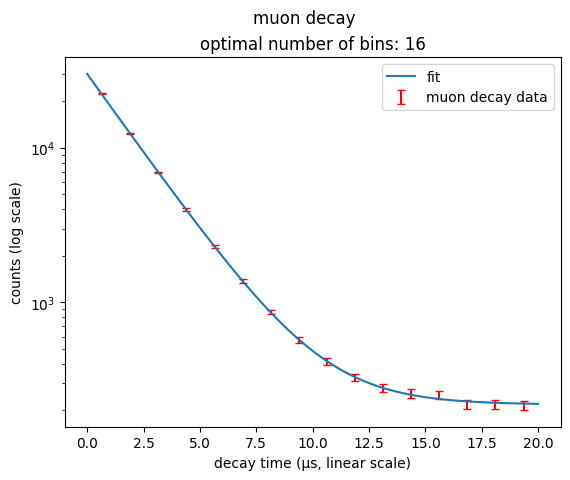

In [38]:
# index is position in errlist that tells
# where minimum uncertainty in tau is
# based on the number of bins
errlist = np.array(errlist)
index = np.where(errlist[:,1]==np.min(errlist[:,1]))[0][0]
nbins = 10+index

# create histogram that minimizes uncertainty
# process is the same as the cell above
# but now we know the number of bins to choose
counts, bins = np.histogram(decaytime, bins=nbins)
bin_centers = np.array([
    (bins[i] + bins[i + 1])/2
    for i in range(len(bins) - 1)
])

nstart = np.searchsorted(bin_centers, [1.5,], side='right')[0]

tau = 2.14
c1 = counts[0]*1.5
c2 = 0
guess = np.array([tau, c1, c2])

popt, pcov = curve_fit(fcn, bin_centers[nstart:], counts[nstart:], guess)

# plotting data (with points, not barlines)
# errors for counting experiments are sqrt of counts
plt.errorbar(
    bin_centers, counts,
    yerr=np.sqrt(counts),
    color='red',
    ls='none',
    capsize=3,
    label='muon decay data'
)

# plotting fit
plt.plot(
    x, fcn(x, *popt),
    label='fit'
)

plt.xlabel('decay time (µs, linear scale)')
plt.ylabel('counts (log scale)')
plt.yscale('log')
plt.legend()
plt.suptitle('muon decay')
plt.title('optimal number of bins: {}'.format(nbins))
plt.show()

In [40]:
errlist = []
for i in range(1001):
    # print i since this calculation takes a bit
    # and it is nice to have a feeling
    # for how much remains
    clear_output()
    print(i)

    # extract histogram information
    counts, bins = np.histogram(decaytime, bins=nbins)

    # obtain bin centers for fitting purposes
    bin_centers = np.array([
        (bins[i] + bins[i + 1])/2
        for i in range(len(bins) - 1)
    ])

    # determine the value of bin_centers where
    # we can start doing the fit
    tstart = (3/1000)*i
    nstart = np.searchsorted(bin_centers, [tstart,], side='right')[0]

    # create a valid guess for the fit
    tau = 2.14
    c1 = counts[0]*1.5
    c2 = 0
    guess = np.array([tau, c1, c2])

    # do the fit on the bin centers
    popt, pcov = curve_fit(fcn, bin_centers[nstart:], counts[nstart:], guess)

    # obtain errors
    perr = np.sqrt(np.diag(pcov))

    # append to error list
    errlist.append([i, perr[0]])

1000


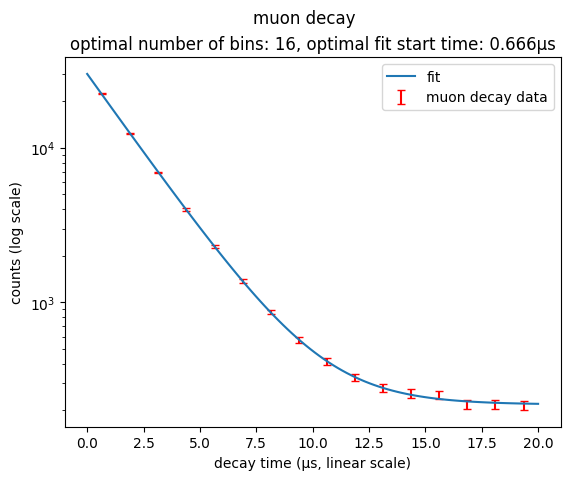

In [52]:
# index is position in errlist that tells
# where minimum uncertainty in tau is
# based on start time
errlist = np.array(errlist)
index = np.where(errlist[:,1]==np.min(errlist[:,1]))[0][0]
tstart = errlist[index][0]*(3/1000)

# create histogram that minimizes uncertainty
# process is the same as the cell above
# but now we know the number of bins
# and the start time to choose
counts, bins = np.histogram(decaytime, bins=nbins)
bin_centers = np.array([
    (bins[i] + bins[i + 1])/2
    for i in range(len(bins) - 1)
])

nstart = np.searchsorted(bin_centers, [tstart,], side='right')[0]

tau = 2.14
c1 = counts[0]*1.5
c2 = 0
guess = np.array([tau, c1, c2])

popt, pcov = curve_fit(fcn, bin_centers[nstart:], counts[nstart:], guess)

# plotting data (with points, not barlines)
# errors for counting experiments are sqrt of counts
plt.errorbar(
    bin_centers, counts,
    yerr=np.sqrt(counts),
    color='red',
    ls='none',
    capsize=3,
    label='muon decay data'
)

# plotting fit
plt.plot(
    x, fcn(x, *popt),
    label='fit'
)

plt.xlabel('decay time (µs, linear scale)')
plt.ylabel('counts (log scale)')
plt.yscale('log')
plt.legend()
plt.suptitle('muon decay')
plt.title(
    'optimal number of bins: {}, '.format(nbins)
    + 'optimal fit start time: {}µs'.format(tstart)
)
plt.show()